In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

ORDER = [0, 2, 3, 1] # Full, Social, Transition, Launcher

In [4]:
all_usage_pix = loadmat('../../all_usage_pixel_v5_IRLS.mat')['all_usage_pixel'][0]  # 4 structs for 4 JIDs
print(len(all_usage_pix))

4


In [7]:
val = all_usage_pix[0].flat[0][0].flat[0]
len(val)

5

# EXTRA 1

(2, 4)
(352, 2)


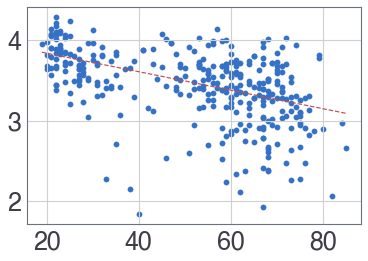

In [51]:
vals = loadmat('../../vals_figure_extra_1.mat')['res'].flat[0]
coeff = vals[0]
values = vals[1]
print(coeff.shape)
print(values.shape)
X = values[:, 0]
Y = values[:, 1]
plt.scatter(X, Y)
plt.plot([min(X), max(X)], np.array([min(X), max(X)]) * coeff[1, 0] + coeff[0, 0], 'r--')

# EXTRA 2

In [17]:
# version = 'v5_IRLS'
# all_jid_aut = loadmat(f'../../all_jid_aut_{version}.mat')['all_jid_aut'][0]
mass_extra_2 = loadmat('../../mass_extra_2.mat')['MASS'][0]
len(mass_extra_2)

4

In [21]:
np.max(mass_extra_2[1])

1.149623024229009

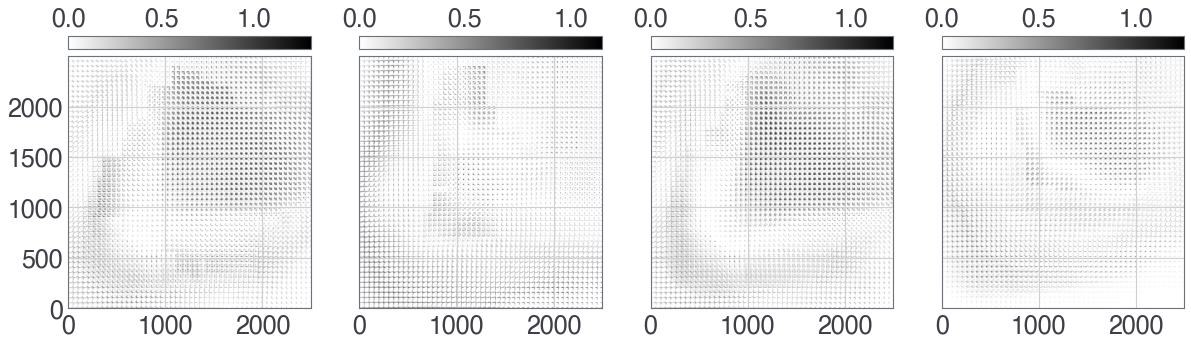

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True, sharex=True)
for i in range(4):
    im = ax[i].imshow(mass_extra_2[i], aspect='auto', cmap='binary')
    ax[i].invert_yaxis()
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
plt.savefig('figure_extra_2.pdf')

# EXTRA 3

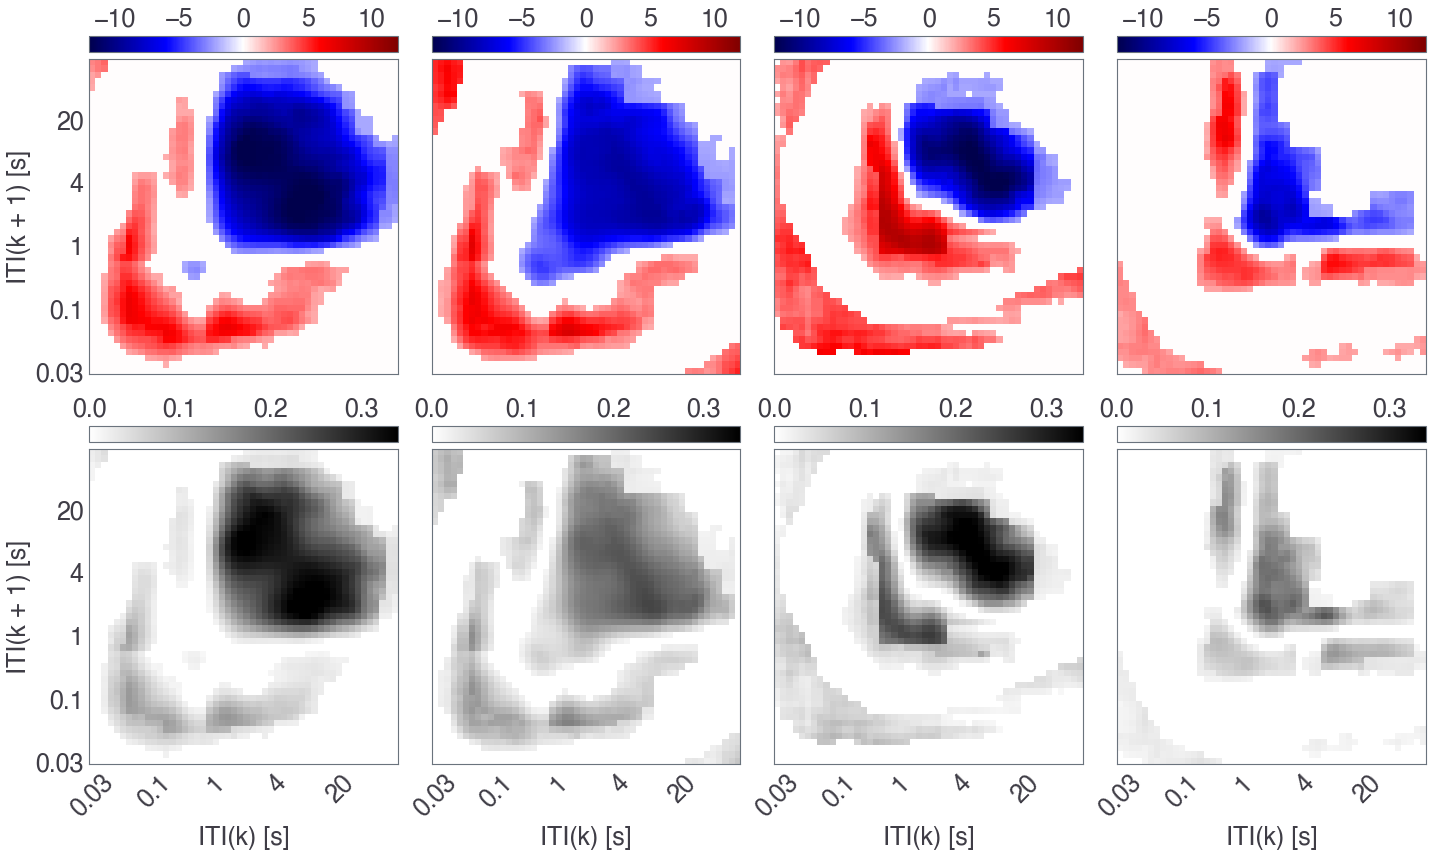

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 12), sharey=True, sharex=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

vmax_f = -np.Inf
vmin_f = np.Inf
vmax_r = -np.Inf
vmin_r = np.Inf

for i in range(4):
    data_it = all_usage_pix[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 1))
    p_uni = np.zeros((2500, 1))
    betas = np.zeros((2500, 2))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]


    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    vmax_f = max(vmax_f, np.percentile(np.sqrt(square_f) * np.sign(k), 99))
    vmin_f = min(vmin_f, np.percentile(np.sqrt(square_f) * np.sign(k), 1))
    
    vmax_r = max(vmax_r, np.percentile(r2_full, 99))
    vmin_r = min(vmin_r, np.percentile(r2_full, 1))

tval_max = max([vmax_f, -vmin_f])

for i, _title in enumerate(['Full', 'Social', 'Transition', 'Launcher']):

    data_it = all_usage_pix[ORDER[i]].flat[0][0].flat[0]
    masks = [m[0].reshape(50, 50).T for m in data_it[0]]
    masks_uni = masks[:-1]
    mask_full = masks[-1]
    mdl = data_it[2]
    f_full = np.zeros(2500)
    r2_full = np.zeros(2500)
    p_full = np.zeros(2500)
    f_uni = np.zeros((2500, 1))
    p_uni = np.zeros((2500, 1))
    betas = np.zeros((2500, 2))

    # mdl is 2500 long
    for j, obj in enumerate(mdl):
        pixel = obj.flat[0][0][0]
        r2_full[j] = pixel[0][0][0]
        f_full[j] = pixel[1][0][0]
        p_full[j] = pixel[2][0][0]
        betas[j] = pixel[3].squeeze()
        continuous = pixel[7][0][0]
        f_uni[j] = continuous[0]
        p_uni[j] = continuous[1]
        

    k = betas[:, 0].reshape(50, 50).T  # T cause of matlab
    square_f = f_uni[:, 0].reshape(50, 50).T
    square_r2_full = r2_full.reshape(50, 50).T
    square_f[square_f < 0] = 0
    
    im = ax[0][i].imshow(np.sign(masks_uni[0]) * np.sqrt(square_f) * np.sign(k), aspect='auto', 
                         cmap='seismic', interpolation='none', norm=TwoSlopeNorm(0, vmin=-tval_max, vmax=tval_max))

    ax[0][i].invert_yaxis()
    ax[0][i].set_xticks(ticks)
    ax[0][i].set_xticklabels(labels)
    ax[0][i].xaxis.set_tick_params(rotation=45)
    ax[0][i].set_yticks(ticks)
    ax[0][i].set_yticklabels(labels)
#     ax[0][i].set_xlabel('ITI(k) [s]')
    ax[0][i].grid(False)
    divider = make_axes_locatable(ax[0][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     cb.set_ticks([0] + list(np.arange(min(_t), max(_t), 2)))
    

    im = ax[1][i].imshow(np.sign(mask_full) * square_r2_full, aspect='auto', cmap='binary', 
                            interpolation='none', norm=Normalize(0, vmax=vmax_r * 0.99))
    ax[1][i].invert_yaxis()
    ax[1][i].set_xticks(ticks)
    ax[1][i].set_xticklabels(labels)
    ax[1][i].xaxis.set_tick_params(rotation=45)
    ax[1][i].set_yticks(ticks)
    ax[1][i].set_yticklabels(labels)
    ax[1][i].set_xlabel('ITI(k) [s]')
    ax[1][i].grid(False)
    divider = make_axes_locatable(ax[1][i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
    _t = cb.get_ticks()
#     _t = cb.set_ticks(np.arange(0.0, max(_t) + .1, .2))
    
ax[0][0].set_ylabel('ITI(k + 1) [s]');
ax[1][0].set_ylabel('ITI(k + 1) [s]');
    
plt.tight_layout()
plt.savefig('figure_extra_3.pdf', transparent=True)

# EXTRA 4

In [54]:
pix_usage = loadmat('../../all_age_gender_usage_pixel_v5_IRLS.mat')['all_age_gender_usage_pixel'][0]
print(len(pix_usage))

4


##### treasure map

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6), sharey=True, sharex=True)
CMAPS = ['b', 'r', 'deeppink', 'limegreen', 'orange', 'dimgrey']
TITLES = ["Age", "Gender", "Usage"] 
labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

x = np.arange(1.5, 5, (5 - 1.5) / 50)
X, Y = np.meshgrid(x, x)
Bs = []
# for i, _title in enumerate(['Full',  'Social', 'Transition', 'Launcher']):
for i, _title in enumerate(['Full']):
    
        data_it = pix_usage[ORDER[i]].flat[0][0].flat[0]
        masks = [m[0].reshape(50, 50).T for m in data_it[0]]
        masks_uni = masks[:-1]
        mask_full = masks[-1]
        mdl = data_it[2]
        Bs.append(data_it[4])
        f_full = np.zeros(2500)
        f_uni = np.zeros((2500, 2))

        # mdl is 2500 long
        for j, obj in enumerate(mdl):
            pixel = obj.flat[0][0][0]
            f_uni[j] = continuous[0]
            if "OLS" in version:
                f_full[j] = pixel[4][0][0]
            else:
                f_full[j] = pixel[1][0][0]

        for IDX, V in enumerate(TITLE):
            square_f = f_uni[:, 0].reshape(50, 50).T
            Z = square_f
            norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
            im = ax[i].contour(Z * np.sign(mask_full) * np.sign(masks_uni[0]), [2], colors=CMAPS[IDX], alpha=.75, norm=norm, linewidths=5)
            
        ax[i].plot([0], [0], color=CMAPS[IDX], label=TITLES[IDX], linewidth=5)
        ax[i].set_xticks(ticks)
        ax[i].set_xticklabels(labels)
        ax[i].xaxis.set_tick_params(rotation=45)
        ax[i].set_yticks(ticks)
        ax[i].set_yticklabels(labels)
        ax[i].set_xlabel('ITI(k) [s]')
        ax[i].grid(False)
ax[0].set_ylabel('ITI(k + 1) [s]')
ax[0].legend(loc='upper center', shadow=True, fancybox=True, ncol=2, bbox_to_anchor=[1, 1.5])
plt.tight_layout()
# plt.savefig('figure_3_panel_d_no_legend.pdf')